<a href="https://colab.research.google.com/github/jhonKifle/Neural-Network/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import random

train = pd.read_csv('/content/sample_data/mnist_train_small.csv')
test = pd.read_csv('/content/sample_data/mnist_test.csv')
train = train._append(train.head(1))
test = test._append(test.head(1))
print(test.shape)
print(train.shape)

(10000, 785)
(20000, 785)


As you can see in above output, the dataset contain 784 bits (28X28) to represent a digits, and one label column to indicate the digit value. So, here we have to split the train set to (train , validation) with (80% , 20%) content of the train set.

In [2]:
valid = train.sample(frac=0.2)
train = train.drop(valid.index)
print(train.shape)
print(valid.shape)

(16000, 785)
(4000, 785)


In [3]:
print(train.head(3))

   6  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.581  0.582  0.583  \
0  5  0    0    0    0    0    0    0    0    0  ...      0      0      0   
2  9  0    0    0    0    0    0    0    0    0  ...      0      0      0   
3  5  0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.584  0.585  0.586  0.587  0.588  0.589  0.590  
0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0  

[3 rows x 785 columns]


Note that the first column is a digit of 0-9, and the rest of 784 bits represent 28 X 28 MNIST image.


See the output of one-hot encoding of the digit 5 is [0,0,0,0,0,1,0,0,0,0], and for 0 it is [1,0,0,0,0,0,0,0,0,0], similarly for the other digits they will contain '1' in their index positions.

In [4]:
train_X = train.iloc[:,1:]
train_y = train.iloc[:,0]

Text(0.5, 1.0, 'digit - 2')

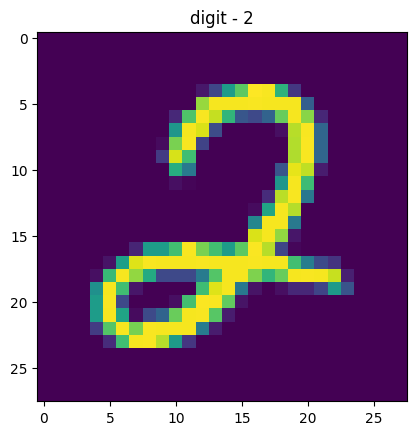

In [5]:
import matplotlib.pyplot as plt
plt.imshow(train_X.iloc[3].values.reshape(28,28))
plt.title("digit - "+str(train_y.iloc[3]))

In [6]:
train_X = train_X/255
train_X = [np.reshape(x, (784, 1)) for x in train_X.values]
valid_X = valid.iloc[:,1:]
valid_X = valid_X/255
valid_X = [np.reshape(x, (784, 1)) for x in valid_X.values]
valid_y = valid.iloc[:,0]
test_X = test.iloc[:,1:]
test_X = test_X/255
test_y = test.iloc[:,0]

To be able to identify which digit, the output shall be defined in some form.
1. We can have 4 bits to represent the binary value of 0-9
2. Or more effiect we can use one-hot encode. For this demo we will use one-hot encode of the output label.

In [7]:
train_y = train.iloc[:,0]
def one_hot(y):
    one_hot_y = [np.zeros((10,1)) for a in y]
    for i,e in zip(y,one_hot_y):
      e[i] = 1
    return one_hot_y
train_y = train_y.to_numpy()
train_y = one_hot(train_y)
valid_y = valid_y.to_numpy()
test_y = one_hot(test_y)

The above image is a 28 X 28 pixel image of a digit from the MNIST dataset. and as it is displayed its label is 5.

Now let us define our network:
- 784 input neurons at the input layer
- 30 neurons at the hidden layer ( depends on user choice)
- 10 output neurons at the output layer

In [8]:

class NN:
  def __init__(self, layers):
    self.layers = layers
    self.weights = []
    self.biases = []
    for i in range(len(layers)-1):
      self.weights.append(np.random.randn(layers[i+1], layers[i]))
      self.biases.append(np.random.randn(layers[i+1], 1))
  def forward(self, X):
    self.inputs = X
    for i in range(len(self.layers)-1):
      self.inputs = np.dot(self.weights[i], self.inputs) + self.biases[i]
      self.inputs = self.sigmoid(self.inputs)
    return self.inputs
  def sigmoid(self, x):
    return 1/(1+np.exp(-x))
  def sigmoid_derivative(self, x):
    return self.sigmoid(x)*(1-self.sigmoid(x))
  def SGD(self, X, y, epochs, batch_size, learning_rate, test_data=None):
    for i in range(epochs):
      for j in range(0, len(X), batch_size):
        X_batch = X[j:j+batch_size]
        y_batch = y[j:j+batch_size]
        self.update_mini_batch(X_batch, y_batch, learning_rate)
      if test_data:
        err = self.evaluate(test_data)
        print("Epoch {} : {} / {} ({}%)".format(i,err,len(test_data[0]),100*err/len(test_data[0])))
      else:
        print("Epoch {} complete".format(i))
  def update_mini_batch(self, X, Y, learning_rate):
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    for x, y in zip(X, Y):
      delta_nabla_b, delta_nabla_w = self.backprop(x, y)
      nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
      nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    self.weights = [w-(learning_rate/len(X))*nw for w, nw in zip(self.weights, nabla_w)]
    self.biases = [b-(learning_rate/len(X))*nb for b, nb in zip(self.biases, nabla_b)]
  def backprop(self, x, y):

    #forward pass: generate weighted sums and sigmoid outputs of each layer
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    activation = x
    activations = [x]
    zs = []
    for b, w in zip(self.biases, self.weights):
      z = np.dot(w, activation)+b
      zs.append(z)
      activation = self.sigmoid(z)
      activations.append(activation)

    #backward propagation
    delta = self.cost(y, activations[-1]) * self.sigmoid_derivative(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())
    for l in range(2, len(self.layers)):
      z = zs[-l]
      sp = self.sigmoid_derivative(z)
      delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
      nabla_b[-l] = delta
      nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
    return (nabla_b, nabla_w)
  def evaluate(self, test_data):
    test_results = [(np.argmax(self.forward(x)), y) for (x, y) in zip(test_data[0], test_data[1])]
    return sum(int(x == y) for (x, y) in test_results)
  def cost(self, y, output):
    return output - y
net = NN([784,30,10])

net.SGD(train_X, train_y, 30, 10, 3.0, test_data=(valid_X,valid_y))


Epoch 0 : 3136 / 4000 (78.4%)
Epoch 1 : 3232 / 4000 (80.8%)
Epoch 2 : 3544 / 4000 (88.6%)
Epoch 3 : 3578 / 4000 (89.45%)
Epoch 4 : 3599 / 4000 (89.975%)
Epoch 5 : 3630 / 4000 (90.75%)
Epoch 6 : 3651 / 4000 (91.275%)
Epoch 7 : 3646 / 4000 (91.15%)
Epoch 8 : 3650 / 4000 (91.25%)
Epoch 9 : 3652 / 4000 (91.3%)
Epoch 10 : 3664 / 4000 (91.6%)
Epoch 11 : 3668 / 4000 (91.7%)
Epoch 12 : 3673 / 4000 (91.825%)
Epoch 13 : 3677 / 4000 (91.925%)
Epoch 14 : 3683 / 4000 (92.075%)
Epoch 15 : 3679 / 4000 (91.975%)
Epoch 16 : 3678 / 4000 (91.95%)
Epoch 17 : 3672 / 4000 (91.8%)
Epoch 18 : 3670 / 4000 (91.75%)
Epoch 19 : 3668 / 4000 (91.7%)
Epoch 20 : 3680 / 4000 (92.0%)
Epoch 21 : 3682 / 4000 (92.05%)
Epoch 22 : 3679 / 4000 (91.975%)
Epoch 23 : 3687 / 4000 (92.175%)
Epoch 24 : 3680 / 4000 (92.0%)
Epoch 25 : 3682 / 4000 (92.05%)
Epoch 26 : 3684 / 4000 (92.1%)
Epoch 27 : 3684 / 4000 (92.1%)
Epoch 28 : 3681 / 4000 (92.025%)
Epoch 29 : 3686 / 4000 (92.15%)


30 Epochs bring a 92% accuracy in new data. This accuracy can be increased by setting randomness of entries in mini_batch. i.e. The mini batchs created were of the same content in every epoch. This can be further enhanced by shuffling the entire data set in every epoch, and creat a new and unique mini-batch contents. To help shuffle, you much join the (X,y) as a list and do the shuffling as follows:

 - random.shuffle(training_data)
